In [1]:
import math
import numpy as np
import pandas as pd
import sys
import re
from functions import *
from mining_functions import *
import seaborn as sns
from scipy import stats
from tabulate import tabulate
np.set_printoptions(precision=2)
pd.set_option('precision', 2)
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
PATH = '/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
def get_path(path = PATH):
    if os.name == 'posix':
        path = '/Documents/code/Phet-log-analyzer/cck/raw_data_parsing_check/'
        return os.environ['HOME']+path #'/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
    elif os.name == 'nt':
        if os.getenv("COMPUTERNAME") == 'PYRRHA':
                path = '/Documents/git/Phet-log-analyzer/cck/raw_data_parsing_check/'
        else:
            path = '/git/Phet-log-analyzer/cck/raw_data_parsing_check/'
        return os.environ['USERPROFILE']+ path.replace('/','\\') #'\\Google Drive\Jonathan Sarah Ido folder\data\CCK\\'
    else:
        raise Exception('OS not recongnized. I\'m confused.')
        
df = pd.read_csv(get_path() + 'phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
# dfx = pd.read_csv('C:\Users\Sarah\Documents\git\Phet-log-analyzer\cck\\raw_data_parsing_check\phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
df["student"] = df["student"].astype('category')
df["Family"]=df["Family"].str.capitalize()
df["Family_tool"]=df["Family_tool"].str.capitalize()
df["Family_default"]=df["Family_default"].str.capitalize()
df["Family_both"]=df["Family_both"].str.capitalize()

df_scores = pd.read_csv(data_path + 'MATCHING_phet_cck_user_data_anonymized.txt')
df_scores["student"] = df_scores["student"].astype('category')


#### Crop activity data to get rid of activity #3

In [3]:
max_time = 25*60*1000
max_times = {s:min(df[df['student']==s]["Time Stamp"])+max_time for s in set(df['student'])}

def keep_by_time (row):
    if row["Time Stamp"] <= max_times[row["student"]]:
        return True
    else: 
        return False

df['keep'] = df.apply (lambda row: keep_by_time (row),axis=1)
df=df[df['keep']]

Functions from the notebook ""

In [4]:
def add_text(attribute,family_category,cut_off, shortest_seq_length, longest_seq_length,B):
    text = """Showing sequences for students split by {0}, using the categories {1}.
            Removed sequences used by less than {2}% of students.
            Found sequences of lenght {3} to {4}.
            Using {5} time bins""".format(attribute,family_category,int(cut_off*100), shortest_seq_length, longest_seq_length,B)
    fig = plt.figure(figsize=(10, 4))
    ax = plt.gca()
    ax.text(0.5,0.5,text,
        horizontalalignment='center',
        verticalalignment='center',
        fontsize = 15)
    plt.axis('off')
    return fig

def rank_sequences(sequence_counts,B,axesnum=None):
    ranks = []
    for seq,counts in sequence_counts.iteritems():
#         if np.sum(counts)>0:
        ranks.append((seq,calc_infogain(counts,B,axesnum)))
    return sorted(ranks, key=lambda tup: tup[1])

def get_top_seqs(ranks,N):
    return ranks[-N:]

In [10]:
df.columns

Index([u'Activity', u'student', u'Time Stamp', u'Family', u'Family_tool',
       u'Family_default', u'Family_both', u'Action', u'Component', u'Outcome',
       u'#circuits', u'#circuits_w_battery', u'#loops', u'#components',
       u'#battery', u'#circuitSwitch', u'#grabBagResistor', u'#lightBulb',
       u'#resistor', u'#seriesAmmeter', u'current_is_circuit',
       u'current_#loops', u'current_#components', u'current_#battery',
       u'current_#circuitSwitch', u'current_#grabBagResistor',
       u'current_#lightBulb', u'current_#resistor', u'current_#seriesAmmeter',
       u'non_default_resistor_values', u'keep'],
      dtype='object')

In [11]:
df_scores.head()

,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,...,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id
0,March,scaff,2,2,0,0,1,1,1,0,...,0.33,2.67,2.78,2.67,4.0,3.50,attitude,scaffolded_attitude,1075123,1920143974
1,March,scaff,2,3,0,0,1,0,1,1,...,-0.12,2.44,3.11,3.33,4.5,3.25,attitude,scaffolded_attitude,3591123,-714775387
2,March,not,2,3,0,0,1,1,1,2,...,-0.72,2.22,2.78,2.44,3.5,3.00,attitude,notscaffolded_attitude,3932129,1194576952
3,March,scaff,2,3,1,1,1,1,1,2,...,-1.18,3.00,3.22,3.11,4.5,3.00,attitude,scaffolded_attitude,4762120,-450686147
4,July,not,1,2,1,0,1,0,1,0,...,-0.18,2.67,3.22,2.78,5.0,3.00,knowledge,notscaffolded_knowledge,4936123,-901793583


### Let's run the sequence mining like we usually but by A1 condition

In [14]:
students = list(get_students())
CUT_OFF = 0.35 #we keep only sequences used once by at least 10% of students
shortest_seq_length = 1
longest_seq_length = 10

### PARAMETERS
attribute = 'scaffolding'
level1 = 'scaff'
level2 = 'not'
family_category = "Family"
axis = 1
group_sizes = np.array([len(set(df_scores[df_scores[attribute]==level1]['student'])),len(set(df_scores[df_scores[attribute]==level2]['student']))])


BINS = 1
sequence_counts_group = get_sequence_use_by_timebin(df,students,family_category,
                                          1,attribute,level1,level2,
                                          shortest_seq_length,longest_seq_length,CUT_OFF,ignore=['I'])
sequence_counts_group = {s:(counts.T/group_sizes).T for s,counts in sequence_counts_group.iteritems()}
tops = get_top_seqs(rank_sequences(sequence_counts_group,BINS,axis),15)

BINS = 4
sequence_counts_both = get_sequence_use_by_timebin(df,students,family_category,
                                  BINS,attribute,level1,level2,
                                  shortest_seq_length,longest_seq_length,CUT_OFF,ignore=['I'])
sequence_counts_both = {s:counts/group_sizes[:,None] for s,counts in sequence_counts_both.iteritems()}

Getting sequence use over 1 time bins for 96 students split by scaffolding. 
    Keeping only sequences used once by at least 35% of students 
    in each group and overall.
Getting sequence use over 4 time bins for 96 students split by scaffolding. 
    Keeping only sequences used once by at least 35% of students 
    in each group and overall.


In [16]:
table = [['SEQ','IG','scaff','not']]
tops.sort(key=lambda x: -x[1])
for seq,ig in tops:
    print seq, round(ig,3), np.ndarray.tolist(sequence_counts_group[seq].T*group_sizes)[0]
    row = [seq,str(round(ig,2))]+ [int(x*100) for x in list(np.ndarray.tolist(sequence_counts_group[seq].T)[0])]
    table.append(row)
print tabulate(table)

TsPCTsP 0.208 [16.0, 5.0]
TbCTbP 0.174 [20.0, 7.0]
CTbCTb 0.106 [20.0, 9.0]
CTcCTcPC 0.094 [9.0, 19.0]
TbCTb 0.091 [25.0, 12.0]
CPCTcP 0.082 [10.0, 20.0]
TsCTsP 0.069 [17.0, 9.0]
CTcCTcCTc 0.069 [9.0, 17.0]
TcCTcCTc 0.062 [11.0, 20.0]
TcPCTcC 0.057 [9.0, 16.0]
PTcPCP 0.057 [16.0, 9.0]
TsPCTc 0.049 [17.0, 10.0]
PCTcPC 0.048 [13.0, 22.0]
CPCTb 0.042 [18.0, 11.0]
PCTsPTs 0.039 [16.0, 10.0]
---------  ----  -----  ---
SEQ        IG    scaff  not
TsPCTsP    0.21  33     10
TbCTbP     0.17  41     14
CTbCTb     0.11  41     18
CTcCTcPC   0.09  18     39
TbCTb      0.09  52     25
CPCTcP     0.08  20     41
TsCTsP     0.07  35     18
CTcCTcCTc  0.07  18     35
TcCTcCTc   0.06  22     41
TcPCTcC    0.06  18     33
PTcPCP     0.06  33     18
TsPCTc     0.05  35     20
PCTcPC     0.05  27     45
CPCTb      0.04  37     22
PCTsPTs    0.04  33     20
---------  ----  -----  ---


I manually reordered and annotated this table here:

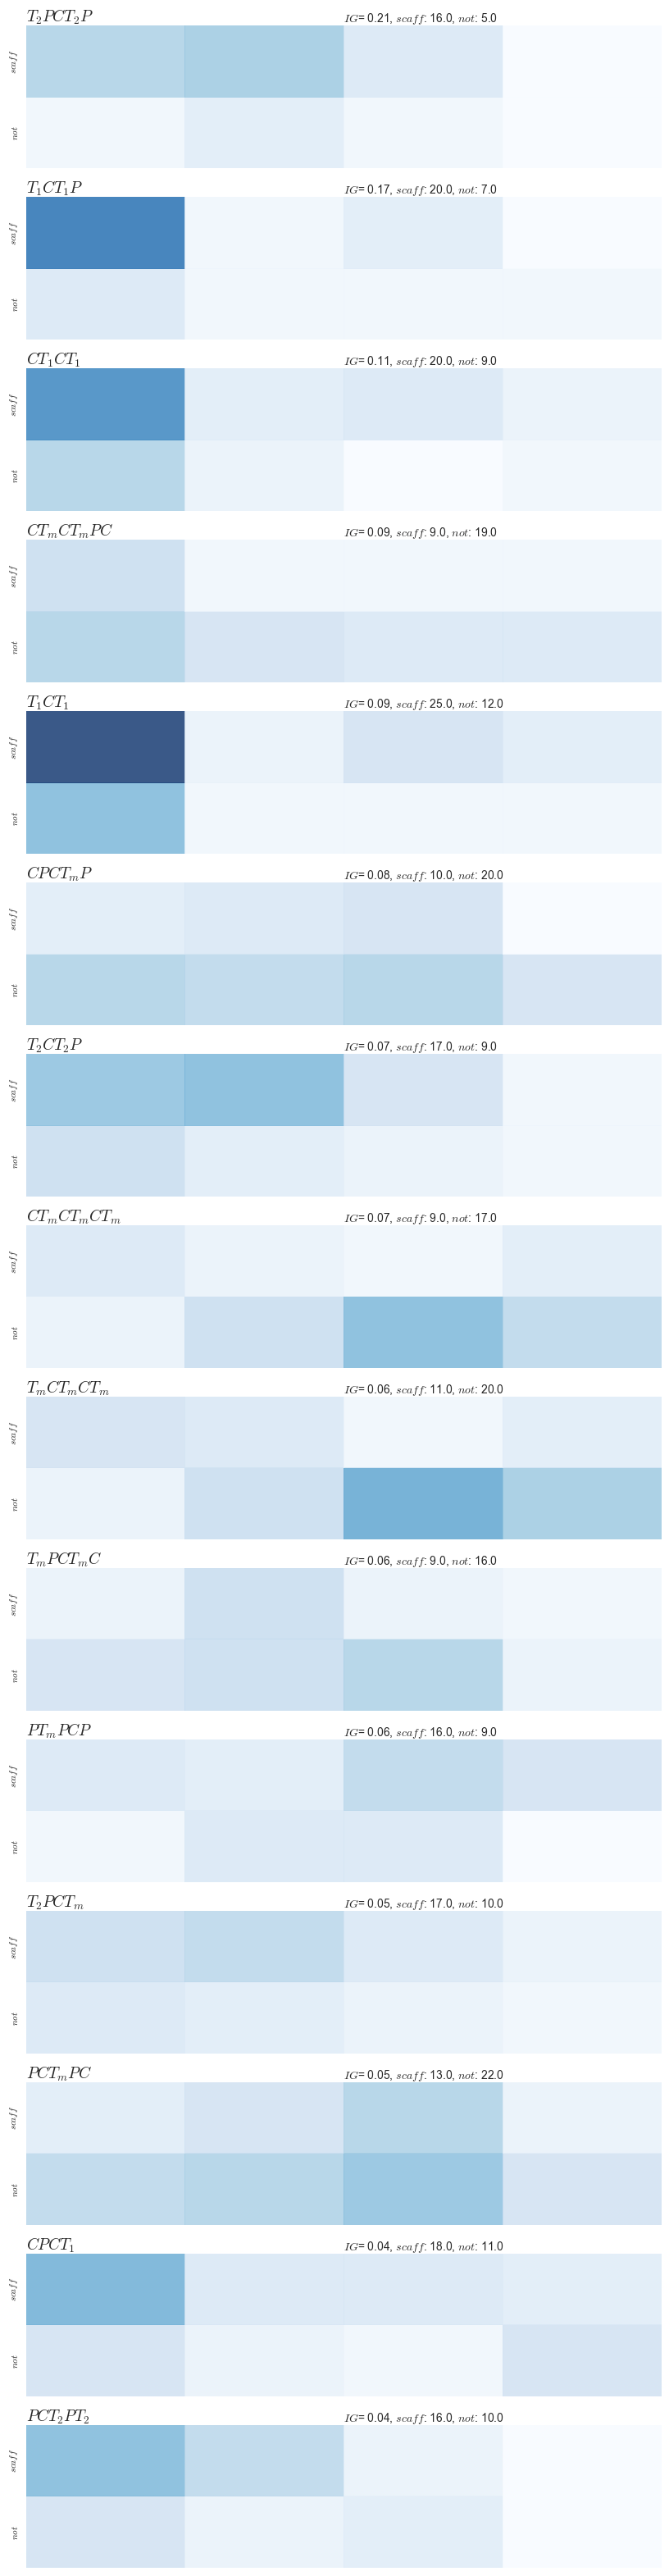

In [21]:
sns.set_style("darkgrid")
sns.set_context("paper")
all_seqs = zip(*tops)[0]
fig, axes = plt.subplots(len(tops),1)#, sharex=True, sharey=True)
maximum = max([np.amax(counts) for seq,counts in sequence_counts_both.iteritems() if seq in all_seqs])
for i,(seq,ig) in enumerate(tops):
    ax = axes[i]
    data = sequence_counts_both[seq]
    ax = axes[i]
    nscaff,nnot = np.ndarray.tolist(sequence_counts_group[seq].T*group_sizes)[0]
    seq = "$"+seq.replace('Ts','T_2').replace('Tb','T_1').replace('Tc','T_m')+"$"
    ax.text(0,2.05, seq, fontsize=14)
    ax.text(2.0,2.05, "$IG$= {0}, $scaff$: {1}, $not$: {2}".format(str(round(ig,2)),nscaff,nnot), fontsize=10)
    
    heatmap = sns.heatmap(data, ax=ax, cmap=plt.cm.Blues,alpha=0.8, vmin=0, vmax=maximum, cbar=False,
                          annot=False) #, annot_kws={'fontweight':'bold'})
    fig.set_size_inches(10,40)
    ax.set_frame_on(False)
    ax.set_yticks(np.arange(data.shape[0]) + 0.5)
    ylabels = ['$not$','$scaff$']
    ax.set_yticklabels(ylabels)
    ax.set_xticklabels(['','','',''])
        
    i += 1